# Sentiment Analysis on IMDB Reviews

This notebook performs sentiment analysis on the IMDB movie review dataset. It explores different text vectorization techniques (TF-IDF, Bag of Words, Word2Vec) and machine learning models (Logistic Regression, Naive Bayes, Decision Tree, Random Forest) to classify reviews as positive or negative.

## Importing Libraries

In [ ]:
# Install necessary libraries
!pip install gensim
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 75.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import spacy
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import gensim
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

## Loading & analysing dataset

In [ ]:
# Load the IMDB dataset from Hugging Face datasets
dataset = load_dataset("imdb")

# Convert train and test splits to pandas DataFrames
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
# Display the dataset structure
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

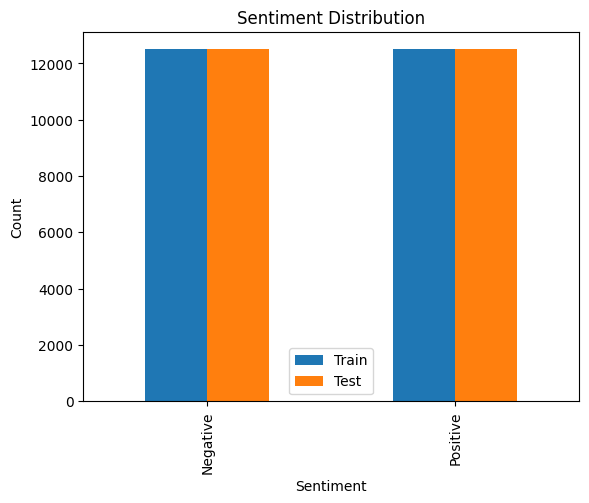

In [ ]:
# Map numerical labels to descriptive sentiment names
label_map = {0: 'Negative', 1: 'Positive'}

# Calculate sentiment distribution for train and test sets
combined_df = pd.DataFrame({
    'Train': train_df['label'].value_counts().sort_index().rename(label_map),
    'Test': test_df['label'].value_counts().sort_index().rename(label_map)
})

# Plot the sentiment distribution
combined_df.plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

## Data pre-processing

In [ ]:
# Load the English small SpaCy model for text processing
nlp = spacy.load('en_core_web_sm')

# Function to preprocess text reviews
def review_to_words(review):
  # Remove HTML tags
  review = re.sub(r'<.*?>', ' ', review)
  # Remove mentions (e.g., @username) and hashtags (e.g., #hashtag)
  review = re.sub(r'(@[A-Za-z0-9]+)|(#\S+)', ' ', review)

  # Process the review using SpaCy for tokenization and lemmatization
  doc = nlp(review.lower())

  tokens = []

  # Filter out stop words and punctuation, then lemmatize tokens
  for token in doc:
    if token.is_stop or token.is_punct:
      continue
    tokens.append(token.lemma_)

  # Join processed tokens back into a string
  return ' '.join(tokens)

# Apply the preprocessing function to the 'text' column of both train and test DataFrames
train_df['processed_text'] = train_df['text'].apply(review_to_words)
test_df['processed_text'] = test_df['text'].apply(review_to_words)

In [ ]:
# Assign processed text to features (X) and labels to target (y) for train and test sets
X_train = train_df['processed_text']
X_test = test_df['processed_text']
y_train = train_df['label']
y_test = test_df['label']

In [ ]:
# Display the first few rows of original and processed text for both train and test sets
print('Train DataFrame (Original vs. Processed Text):')
print(train_df[['text', 'processed_text']].head())
print('\nTest DataFrame (Original vs. Processed Text):')
print(test_df[['text', 'processed_text']].head())

Train DataFrame (Original vs. Processed Text):
                                                text  \
0  I rented I AM CURIOUS-YELLOW from my video sto...   
1  "I Am Curious: Yellow" is a risible and preten...   
2  If only to avoid making this type of film in t...   
3  This film was probably inspired by Godard's Ma...   
4  Oh, brother...after hearing about this ridicul...   

                                      processed_text  
0  rent curious yellow video store controversy su...  
1  curious yellow risible pretentious steaming pi...  
2  avoid make type film future film interesting e...  
3  film probably inspire godard masculin féminin ...  
4  oh brother hear ridiculous film umpteen year t...  

Test DataFrame (Original vs. Processed Text):
                                                text  \
0  I love sci-fi and am willing to put up with a ...   
1  Worth the entertainment value of a rental, esp...   
2  its a totally average film with a few semi-alr...   
3  STAR RATING:

In [ ]:
results = []

#TF-IDF

In [ ]:
# Initialize TF-IDF Vectorizer with a maximum of 5000 features and unigrams/bigrams
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit the vectorizer on the training data and transform both training and testing data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

## Logistic Regression

In [ ]:
# Initialize Logistic Regression model with increased max_iter for convergence and balanced class weights
model_lr_tfidf = LogisticRegression(max_iter=1000, class_weight='balanced')

# Train the model on TF-IDF transformed training data
model_lr_tfidf.fit(X_train_tfidf, y_train)

# Make predictions on TF-IDF transformed test data
y_pred_lr_tfidf = model_lr_tfidf.predict(X_test_tfidf)

# Print evaluation metrics for Logistic Regression with TF-IDF
print('\nLogistic Regression (TF-IDF)')
print('Accuracy: ', accuracy_score(y_test, y_pred_lr_tfidf) * 100)
print(classification_report(y_test, y_pred_lr_tfidf))
print(confusion_matrix(y_test, y_pred_lr_tfidf))


Logistic Regression (TF-IDF)
Accuracy:  87.644
              precision    recall  f1-score   support

           0       0.88      0.87      0.88     12500
           1       0.87      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

[[10885  1615]
 [ 1474 11026]]


In [ ]:
# Append Logistic Regression (TF-IDF) results to the results list
results.append({'Vectorizer': 'Tfidf', 'Model': 'Logistic Regression', 'Accuracy': accuracy_score(y_test, y_pred_lr_tfidf)})

## Naive Bayes

In [ ]:
# Initialize Multinomial Naive Bayes model
model_nb_tfidf = MultinomialNB()

# Train the model on TF-IDF transformed training data
model_nb_tfidf.fit(X_train_tfidf, y_train)

# Make predictions on TF-IDF transformed test data
y_pred_nb_tfidf = model_nb_tfidf.predict(X_test_tfidf)

# Print evaluation metrics for Naive Bayes with TF-IDF
print('\nNaive Bayes (TF-IDF)')
print('Accuracy: ', accuracy_score(y_test, y_pred_nb_tfidf) * 100)
print(classification_report(y_test, y_pred_nb_tfidf))
print(confusion_matrix(y_test, y_pred_nb_tfidf))


Naive Bayes (TF-IDF)
Accuracy:  84.188
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     12500
           1       0.84      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

[[10558  1942]
 [ 2011 10489]]


In [ ]:
# Append Naive Bayes (TF-IDF) results to the results list
results.append({'Vectorizer': 'Tfidf', 'Model': 'Naive Bayes', 'Accuracy': accuracy_score(y_test, y_pred_nb_tfidf)})

## Decision Tree

In [ ]:
# Initialize Decision Tree Classifier
model_dt_tfidf = tree.DecisionTreeClassifier()

# Train the model on TF-IDF transformed training data
model_dt_tfidf.fit(X_train_tfidf, y_train)

# Make predictions on TF-IDF transformed test data
y_pred_dt_tfidf = model_dt_tfidf.predict(X_test_tfidf)

# Print evaluation metrics for Decision Tree with TF-IDF
print('\nDecision Tree (TF-IDF)')
print('Accuracy: ', accuracy_score(y_test, y_pred_dt_tfidf) * 100)
print(classification_report(y_test, y_pred_dt_tfidf))
print(confusion_matrix(y_test, y_pred_dt_tfidf))


Decision Tree (TF-IDF)
Accuracy:  71.288
              precision    recall  f1-score   support

           0       0.71      0.71      0.71     12500
           1       0.71      0.71      0.71     12500

    accuracy                           0.71     25000
   macro avg       0.71      0.71      0.71     25000
weighted avg       0.71      0.71      0.71     25000

[[8928 3572]
 [3606 8894]]


In [ ]:
# Append Decision Tree (TF-IDF) results to the results list
results.append({'Vectorizer': 'Tfidf', 'Model': 'Decision Tree', 'Accuracy': accuracy_score(y_test, y_pred_dt_tfidf)})

## Random Forest

In [ ]:
# Initialize Random Forest Classifier with 100 estimators and a fixed random state
model_rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on TF-IDF transformed training data
model_rf_tfidf.fit(X_train_tfidf, y_train)

# Make predictions on TF-IDF transformed test data
y_pred_rf_tfidf = model_rf_tfidf.predict(X_test_tfidf)

# Print evaluation metrics for Random Forest with TF-IDF
print('\nRandom Forest (TF-IDF)')
print('Accuracy: ', accuracy_score(y_test, y_pred_rf_tfidf) * 100)
print(classification_report(y_test, y_pred_rf_tfidf))
print(confusion_matrix(y_test, y_pred_rf_tfidf))


Random Forest (TF-IDF)
Accuracy:  84.128
              precision    recall  f1-score   support

           0       0.83      0.86      0.84     12500
           1       0.85      0.83      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

[[10698  1802]
 [ 2166 10334]]


In [ ]:
# Append Random Forest (TF-IDF) results to the results list
results.append({'Vectorizer': 'Tfidf', 'Model': 'Random Forest', 'Accuracy': accuracy_score(y_test, y_pred_rf_tfidf)})

# Bag of Words

In [ ]:
# Initialize Count Vectorizer (Bag of Words) with a maximum of 5000 features and unigrams/bigrams
bow = CountVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit the vectorizer on the training data and transform both training and testing data
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)

## Logistic Regression

In [ ]:
# Initialize Logistic Regression model with increased max_iter for convergence and balanced class weights
model_lr_bow = LogisticRegression(max_iter=1000, class_weight='balanced')

# Train the model on BoW transformed training data
model_lr_bow.fit(X_train_bow, y_train)

# Make predictions on BoW transformed test data
y_pred_lr_bow = model_lr_bow.predict(X_test_bow)

# Print evaluation metrics for Logistic Regression with BoW
print('\nLogistic Regression (BoW)')
print('Accuracy: ', accuracy_score(y_test, y_pred_lr_bow) * 100)
print(classification_report(y_test, y_pred_lr_bow))
print(confusion_matrix(y_test, y_pred_lr_bow))


Logistic Regression (BoW)
Accuracy:  84.248
              precision    recall  f1-score   support

           0       0.83      0.85      0.84     12500
           1       0.85      0.83      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

[[10683  1817]
 [ 2121 10379]]


In [ ]:
# Append Logistic Regression (BoW) results to the results list
results.append({'Vectorizer': 'BoW', 'Model': 'Logistic Regression', 'Accuracy': accuracy_score(y_test, y_pred_lr_bow)})

## Naive Bayes

In [ ]:
# Initialize Multinomial Naive Bayes model
model_nb_bow = MultinomialNB()

# Train the model on BoW transformed training data
model_nb_bow.fit(X_train_bow, y_train)

# Make predictions on BoW transformed test data
y_pred_nb_bow = model_nb_bow.predict(X_test_bow)

# Print evaluation metrics for Naive Bayes with BoW
print('\nNaive Bayes (BoW)')
print('Accuracy: ', accuracy_score(y_test, y_pred_nb_bow) * 100)
print(classification_report(y_test, y_pred_nb_bow))
print(confusion_matrix(y_test, y_pred_nb_bow))


Naive Bayes (BoW)
Accuracy:  83.8
              precision    recall  f1-score   support

           0       0.83      0.85      0.84     12500
           1       0.85      0.83      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

[[10637  1863]
 [ 2187 10313]]


In [ ]:
# Append Naive Bayes (BoW) results to the results list
results.append({'Vectorizer': 'BoW', 'Model': 'Naive Bayes', 'Accuracy': accuracy_score(y_test, y_pred_nb_bow)})

## Decision Tree

In [ ]:
# Initialize Decision Tree Classifier
model_dt_bow = tree.DecisionTreeClassifier()

# Train the model on BoW transformed training data
model_dt_bow.fit(X_train_bow, y_train)

# Make predictions on BoW transformed test data
y_pred_dt_bow = model_dt_bow.predict(X_test_bow)

# Print evaluation metrics for Decision Tree with BoW
print('\nDecision Tree (BoW)')
print('Accuracy: ', accuracy_score(y_test, y_pred_dt_bow) * 100)
print(classification_report(y_test, y_pred_dt_bow))
print(confusion_matrix(y_test, y_pred_dt_bow))


Decision Tree (BoW)
Accuracy:  71.284
              precision    recall  f1-score   support

           0       0.71      0.72      0.71     12500
           1       0.72      0.71      0.71     12500

    accuracy                           0.71     25000
   macro avg       0.71      0.71      0.71     25000
weighted avg       0.71      0.71      0.71     25000

[[8997 3503]
 [3676 8824]]


In [ ]:
# Append Decision Tree (BoW) results to the results list
results.append({'Vectorizer': 'BoW', 'Model': 'Decision Tree', 'Accuracy': accuracy_score(y_test, y_pred_dt_bow)})

## Random Forest

In [ ]:
# Initialize Random Forest Classifier with 100 estimators and a fixed random state
model_rf_bow = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on BoW transformed training data
model_rf_bow.fit(X_train_bow, y_train)

# Make predictions on BoW transformed test data
y_pred_rf_bow = model_rf_bow.predict(X_test_bow)

# Print evaluation metrics for Random Forest with BoW
print('\nRandom Forest (BoW)')
print('Accuracy: ', accuracy_score(y_test, y_pred_rf_bow) * 100)
print(classification_report(y_test, y_pred_rf_bow))
print(confusion_matrix(y_test, y_pred_rf_bow))


Random Forest (BoW)
Accuracy:  84.332
              precision    recall  f1-score   support

           0       0.84      0.85      0.84     12500
           1       0.85      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

[[10640  1860]
 [ 2057 10443]]


In [ ]:
# Append Random Forest (BoW) results to the results list
results.append({'Vectorizer': 'BoW', 'Model': 'Random Forest', 'Accuracy': accuracy_score(y_test, y_pred_rf_bow)})

# Word2Vec

In [ ]:
# Tokenize processed text into lists of words for Word2Vec training
sentences_train =  [simple_preprocess(text) for text in X_train]
sentences_test = [simple_preprocess(text) for text in X_test]

In [ ]:
# Display the first processed sentence from the training set
sentences_train[0]

['rent',
 'curious',
 'yellow',
 'video',
 'store',
 'controversy',
 'surround',
 'release',
 'hear',
 'seize',
 'customs',
 'try',
 'enter',
 'country',
 'fan',
 'film',
 'consider',
 'controversial',
 'plot',
 'center',
 'young',
 'swedish',
 'drama',
 'student',
 'name',
 'lena',
 'want',
 'learn',
 'life',
 'particular',
 'want',
 'focus',
 'attention',
 'make',
 'sort',
 'documentary',
 'average',
 'swede',
 'think',
 'certain',
 'political',
 'issue',
 'vietnam',
 'war',
 'race',
 'issue',
 'united',
 'states',
 'ask',
 'politician',
 'ordinary',
 'denizen',
 'stockholm',
 'opinion',
 'politic',
 'sex',
 'drama',
 'teacher',
 'classmate',
 'married',
 'man',
 'kill',
 'curious',
 'yellow',
 'year',
 'ago',
 'consider',
 'pornographic',
 'sex',
 'nudity',
 'scene',
 'far',
 'shoot',
 'like',
 'cheaply',
 'porno',
 'countryman',
 'mind',
 'find',
 'shocking',
 'reality',
 'sex',
 'nudity',
 'major',
 'staple',
 'swedish',
 'cinema',
 'ingmar',
 'bergman',
 'arguably',
 'answer',
 '

In [ ]:
# Initialize Word2Vec model with specified parameters
w2v_model = Word2Vec(
    window = 10, # Maximum distance between the current and predicted word within a sentence
    min_count = 2, # Ignores all words with total frequency lower than this
    workers = 5 # Use these many worker threads to train the model
)

In [ ]:
# Build the vocabulary from the training sentences
w2v_model.build_vocab(sentences_train)

# Train the Word2Vec model
w2v_model.train(sentences_train, total_examples = w2v_model.corpus_count, epochs = w2v_model.epochs)

(12095053, 12986860)

In [ ]:
# Function to create a vector representation for a sentence by averaging word vectors
def sentence_vector(tokens):
    vectors = []
    for tok in tokens:
        # Check if the word is in the vocabulary
        if tok in w2v_model.wv:
            vectors.append(w2v_model.wv[tok])
    # If no words in the sentence are in the vocabulary, return a zero vector
    if len(vectors) == 0:
        return np.zeros(w2v_model.vector_size) # Use model's vector size
    # Otherwise, return the mean of all word vectors in the sentence
    return np.mean(vectors, axis=0)

# Create sentence vectors for training and testing data
X_train_w2v = np.vstack([sentence_vector(s) for s in sentences_train])
X_test_w2v = np.vstack([sentence_vector(s) for s in sentences_test])

## Logistic Regression

In [ ]:
# Initialize Logistic Regression model with increased max_iter for convergence
model_lr_w2v = LogisticRegression(max_iter=1000)

# Train the model on Word2Vec transformed training data
model_lr_w2v.fit(X_train_w2v, y_train)

# Make predictions on Word2Vec transformed test data
y_pred_lr_w2v = model_lr_w2v.predict(X_test_w2v)

# Print evaluation metrics for Logistic Regression with Word2Vec
print("\nLogistic Regression (Word2Vec)")
print("Accuracy:", accuracy_score(y_test, y_pred_lr_w2v) * 100)
print(classification_report(y_test, y_pred_lr_w2v))
print(confusion_matrix(y_test, y_pred_lr_w2v))


Logistic Regression (Word2Vec)
Accuracy: 80.964
              precision    recall  f1-score   support

           0       0.81      0.81      0.81     12500
           1       0.81      0.81      0.81     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000

[[10098  2402]
 [ 2357 10143]]


In [ ]:
# Append Logistic Regression (Word2Vec) results to the results list
results.append({'Vectorizer': 'Word2Vec', 'Model': 'Logistic Regression', 'Accuracy': accuracy_score(y_test, y_pred_lr_w2v)})

## Naive Bayes

In [ ]:
# MultinomialNB cannot handle negative input values, which are present in Word2Vec embeddings.
# Therefore, we will skip training Naive Bayes with Word2Vec embeddings and record 0 accuracy.

print("\nNaive Bayes (Word2Vec) - Skipped due to negative values in embeddings.")


Naive Bayes (Word2Vec) - Skipped due to negative values in embeddings.


In [ ]:
# Append Naive Bayes (Word2Vec) results with 0 accuracy to the results list
results.append({'Vectorizer': 'Word2Vec', 'Model': 'Naive Bayes', 'Accuracy': 0})

## Decision Tree

In [ ]:
# Initialize Decision Tree Classifier
model_dt_w2v = tree.DecisionTreeClassifier()

# Train the model on Word2Vec transformed training data
model_dt_w2v.fit(X_train_w2v, y_train)

# Make predictions on Word2Vec transformed test data
y_pred_dt_w2v = model_dt_w2v.predict(X_test_w2v)

# Print evaluation metrics for Decision Tree with Word2Vec
print("\nDecision Tree (Word2Vec)")
print("Accuracy:", accuracy_score(y_test, y_pred_dt_w2v) * 100)
print(classification_report(y_test, y_pred_dt_w2v))
print(confusion_matrix(y_test, y_pred_dt_w2v))


Decision Tree (Word2Vec)
Accuracy: 67.932
              precision    recall  f1-score   support

           0       0.67      0.70      0.68     12500
           1       0.69      0.66      0.67     12500

    accuracy                           0.68     25000
   macro avg       0.68      0.68      0.68     25000
weighted avg       0.68      0.68      0.68     25000

[[8690 3810]
 [4207 8293]]


In [ ]:
# Append Decision Tree (Word2Vec) results to the results list
results.append({'Vectorizer': 'Word2Vec', 'Model': 'Decision Tree', 'Accuracy': accuracy_score(y_test, y_pred_dt_w2v)})

## Random Forest

In [ ]:
# Initialize Random Forest Classifier with 100 estimators and a fixed random state
model_rf_w2v = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on Word2Vec transformed training data
model_rf_w2v.fit(X_train_w2v, y_train)

# Make predictions on Word2Vec transformed test data
y_pred_rf_w2v = model_rf_w2v.predict(X_test_w2v)

# Print evaluation metrics for Random Forest with Word2Vec
print('\nRandom Forest (Word2Vec)')
print('Accuracy: ', accuracy_score(y_test, y_pred_rf_w2v) * 100)
print(classification_report(y_test, y_pred_rf_w2v))
print(confusion_matrix(y_test, y_pred_rf_w2v))


Random Forest (Word2Vec)
Accuracy:  78.08
              precision    recall  f1-score   support

           0       0.78      0.77      0.78     12500
           1       0.78      0.79      0.78     12500

    accuracy                           0.78     25000
   macro avg       0.78      0.78      0.78     25000
weighted avg       0.78      0.78      0.78     25000

[[9669 2831]
 [2649 9851]]


In [ ]:
# Append Random Forest (Word2Vec) results to the results list
results.append({'Vectorizer': 'Word2Vec', 'Model': 'Random Forest', 'Accuracy': accuracy_score(y_test, y_pred_rf_w2v)})

# Results

In [ ]:
# Create a DataFrame from the collected results
results_df = pd.DataFrame(results, columns=['Vectorizer', 'Model', 'Accuracy'])

In [ ]:
# Display the results DataFrame
results_df

,Vectorizer,Model,Accuracy
0,Tfidf,Logistic Regression,0.87644
1,Tfidf,Naive Bayes,0.84188
2,Tfidf,Decision Tree,0.71288
3,Tfidf,Random Forest,0.84128
4,BoW,Logistic Regression,0.84248
5,BoW,Naive Bayes,0.83800
6,BoW,Decision Tree,0.71284
7,BoW,Random Forest,0.84332
8,Word2Vec,Logistic Regression,0.80964
9,Word2Vec,Naive Bayes,0.00000


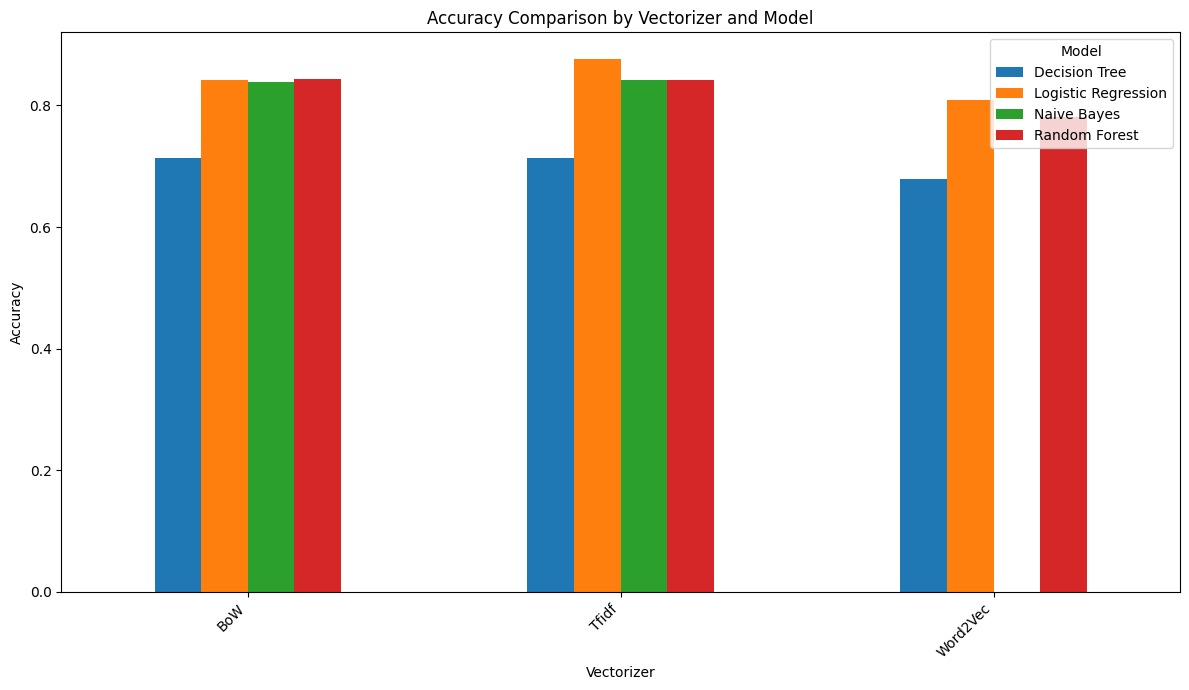

In [ ]:
# Create a pivot table to easily compare accuracy across vectorizers and models
pivot_df = results_df.pivot(index='Vectorizer', columns='Model', values='Accuracy')

# Plot the accuracy comparison as a bar chart
pivot_df.plot(kind='bar', figsize=(12, 7))
plt.title('Accuracy Comparison by Vectorizer and Model')
plt.xlabel('Vectorizer')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()